In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
max_price = 20
conversion_probability = lambda p: 1-p/max_price

In [4]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t): # n_t is the number of customers
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t)) # TODO: prova una gaussiana
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t

In [4]:
class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

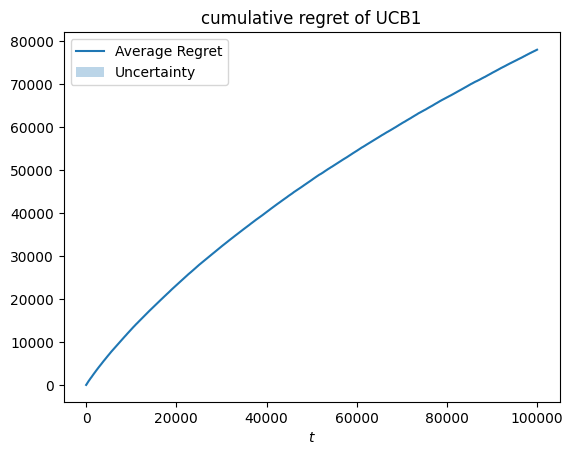

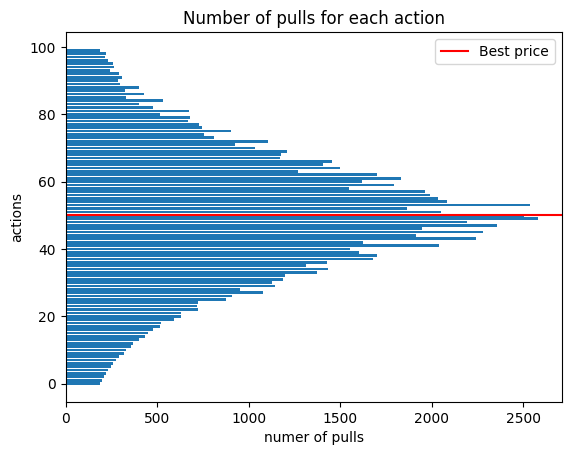

In [6]:
T = 100000 # try T=100, why this behavior?
K = 100

cost = 0
prices = np.linspace(cost,max_price,K) # 100 actions!

n_customers = 1 # I assume the number of customers arriving is the same everyday (for now, in general this is not true)

reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

# let's compute the clairvoyant
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
    ucb_agent = UCB1Agent(K, T, range=maximum_profit)

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        d_t, r_t = env.round(p_t, n_customers)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(100), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show()

# 1.2

In [2]:
# the agent does not need the values of the available bids or the valuation
# the first bid is 0
class UCBLikeAgent():
    def __init__(self, K, B, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None # it's an index, not the actual bid
        self.avg_f = np.zeros(K)
        self.avg_c = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.budget = B
        self.rho = B/T
        self.t = 0
    
    def pull_arm(self):
        if self.budget < 1:
            self.a_t = 0
            return -1
        if self.t < self.K:
            self.a_t = self.t 
        else:
            f_ucbs = self.avg_f + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            c_lcbs = self.avg_c - self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            gamma_t = self.compute_opt(f_ucbs, c_lcbs)
            self.a_t = np.random.choice(self.K, p=gamma_t)
        return self.a_t

    def compute_opt(self, f_ucbs, c_lcbs):
        if np.sum(c_lcbs <= np.zeros(len(c_lcbs))):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1
            return gamma
        c = -f_ucbs
        A_ub = [c_lcbs]
        b_ub = [self.rho]
        A_eq = [np.ones(self.K)]
        b_eq = [1]
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
        gamma = res.x
        return gamma
    
    def update(self, f_t, c_t):
        self.N_pulls[self.a_t] += 1
        self.avg_f[self.a_t] += (f_t - self.avg_f[self.a_t])/self.N_pulls[self.a_t]
        self.avg_c[self.a_t] += (c_t - self.avg_c[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t
        self.t += 1

In [24]:
class FirstPriceAuction:
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        payment = bids[winners]
        return payment
    
    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [25]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t): # n_t is the number of customers
        if p_t == 0:
            return 0, 0
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t)) # TODO: prova una gaussiana
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t

In [22]:
B = 200
T = 1000

conversion_probability = lambda p: 1-p/max_price
price_from_conversion = lambda c: max_price * (1 - c)

optimal_price_1 = price_from_conversion(B/T + 0.01)
optimal_price = price_from_conversion(B/T) 
print(f"Optimal price: {optimal_price}, Optimal price 1: {optimal_price_1}")



Optimal price: 16.0, Optimal price 1: 15.8


In [26]:
B = 200
T = 1000
K = 100

max_price = 20
cost = 0
prices = np.linspace(cost,max_price,K) # 100 actions!

conversion_probability = lambda p: 1-p/max_price

agent = UCBLikeAgent(K=K, 
                     B=B,
                     T=T,
                     range=1) # TODO: vedi meglio questo range
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

reward_function = lambda price, n_sales: (price-cost)*n_sales
profit_curve = reward_function(prices, 1*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

# best_price_index = np.abs(prices - B/T).argmin()
# best_price = prices[best_price_index]

regret_per_trial = []

n_trials = 2
for seed in range(n_trials):
    np.random.seed(17)
    agent_regrets = np.array([])
    for u in range(T):

        my_p_index = agent.pull_arm()
        my_p = prices[my_p_index]

        d_t, r_t = env.round(my_p, 1)
        # d_t è zero se il tizio non ha comprato o 1 se ha comprato

        agent.update(r_t, d_t)
        best = profit_curve[best_price_index] if agent.budget >= 1 else 0
        regret = best - r_t
        agent_regrets = np.append(agent_regrets, regret)

    cumulative_regret = np.cumsum(agent_regrets)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)



In [14]:
agent_rewards

array([], dtype=float64)

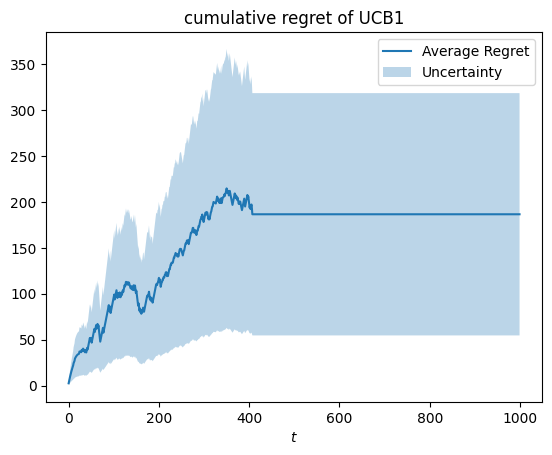

In [27]:
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

# Tests

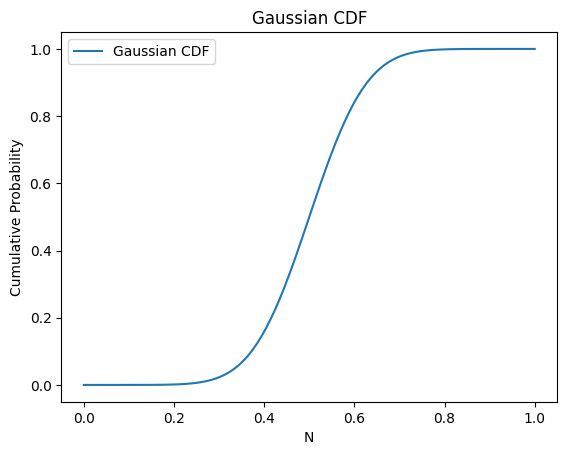

In [30]:
from scipy.stats import norm
def make_gaussian_cdf(M, sigma):
    if 0 >= M or sigma <= 0:
        raise ValueError("M must be positive and sigma must be positive")

    def gaussian_cdf(N):
        return norm.cdf(N, loc=M, scale=sigma)
    
    return gaussian_cdf

samples_x = np.linspace(0, 1, 100)
gaussian_cdf = make_gaussian_cdf(0.5, 0.1)
# samples_y = [gaussian_cdf(x) for x in samples_x]
samples_y = gaussian_cdf(samples_x)
plt.plot(samples_x, samples_y, label='Gaussian CDF')
plt.title('Gaussian CDF')
plt.xlabel('N')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

In [ ]:
B = 200
T = 1000
K = 100

buyer_cdf = make_gaussian_cdf(0.5, 0.1)

max_price = 20
cost = 0
prices = np.linspace(cost,max_price,K) # 100 actions!

conversion_probability = lambda p: 1-p/max_price

agent = UCBLikeAgent(K=K, 
                     B=B,
                     T=T,
                     range=1) # TODO: vedi meglio questo range
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

# reward_function = lambda price, n_sales: (price-cost)*n_sales
# profit_curve = reward_function(prices, 1*conversion_probability(prices))
# best_price_index = np.argmax(profit_curve)
# best_price = prices[best_price_index]
# expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

# best_price_index = np.abs(prices - B/T).argmin()
# best_price = prices[best_price_index]

regret_per_trial = []

n_trials = 2
for seed in range(n_trials):
    np.random.seed(seed)
    agent_regrets = np.array([])
    for u in range(T):

        my_p_index = agent.pull_arm()
        my_p = prices[my_p_index]

        # d_t, r_t = env.round(my_p, 1)
        # d_t è zero se il tizio non ha comprato o 1 se ha comprato

        

        agent.update(r_t, d_t)
        best = profit_curve[best_price_index] if agent.budget >= 1 else 0
        regret = best - r_t
        agent_regrets = np.append(agent_regrets, regret)

    cumulative_regret = np.cumsum(agent_regrets)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

# Neniiiii

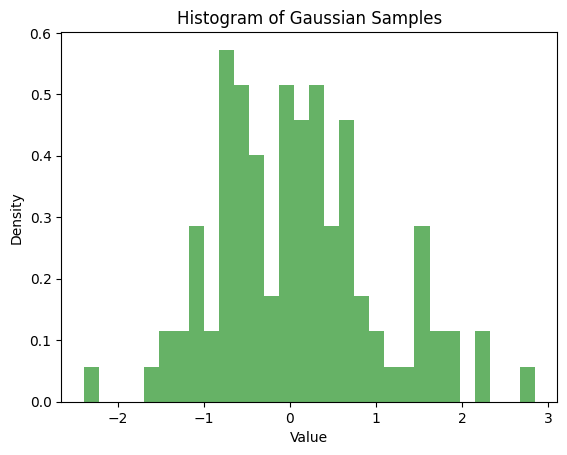

In [3]:
def make_gaussian_sampler(mean=0.0, std_dev=1.0):
    def func(_N):
        return np.random.normal(loc=mean, scale=std_dev, size=_N)
    return func

samples = make_gaussian_sampler()(100)
plt.hist(samples, bins=30, density=True, alpha=0.6, color='g')
plt.title('Histogram of Gaussian Samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

In [4]:
class PricingEnvironment:
    def __init__(self, T: int, sampler):
        self.T = T
        self.values = sampler(T)
        
    def round(self, p_t, t) -> bool:
        """Returns True if the buyer accepts the price at time t."""
        v_t = self.values[t]
        return v_t >= p_t

Best price: 12.195121951219512 (arm 25), Total reward: 3658.5365853658363


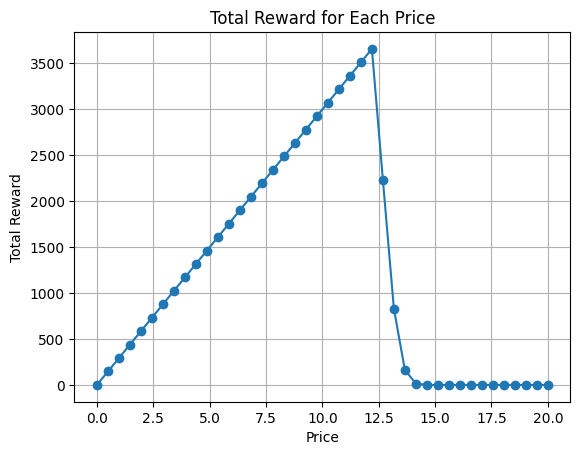

In [21]:
buyer_value = 12
buyer_indecision = 0.75
buyer_sampler = make_gaussian_sampler(mean=buyer_value, std_dev=buyer_indecision)

T = 1000
K = 42
B = 300

env = PricingEnvironment(T=T, sampler=buyer_sampler)

prices = np.linspace(0, 20, K)

rewards = []
for p in prices:
    reward = sum([p for t in range(T) if env.round(p, t)][:B])
    rewards.append(reward)

best_arm = np.argmax(rewards)
print(f"Best price: {prices[best_arm]} (arm {best_arm}), Total reward: {rewards[best_arm]}")

plt.plot(prices, rewards, marker='o')
plt.title('Total Reward for Each Price')
plt.xlabel('Price')
plt.ylabel('Total Reward')
plt.grid()
plt.show()

In [22]:
# B = 200
# T = 1000
# K = 100

# buyer_value = 12
# buyer_indecision = 0.75
# buyer_sampler = make_gaussian_sampler(mean=buyer_value, std_dev=buyer_indecision)

# max_price = 20
# cost = 0
# prices = np.linspace(cost,max_price,K) # 100 actions!

# conversion_probability = lambda p: 1-p/max_price

agent = UCBLikeAgent(K=K, 
                     B=B,
                     T=T,
                     range=1) # TODO: vedi meglio questo range
# env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

# reward_function = lambda price, n_sales: (price-cost)*n_sales
# profit_curve = reward_function(prices, 1*conversion_probability(prices))
# best_price_index = np.argmax(profit_curve)
# best_price = prices[best_price_index]
# expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

# best_price_index = np.abs(prices - B/T).argmin()
# best_price = prices[best_price_index]

best_price_index = 27
best_price = prices[best_price_index]

regret_per_trial = []

best_remaining_budget = B

budget_finito = float("inf")

n_trials = 1
for seed in range(n_trials):
    np.random.seed(seed)
    agent_regrets = np.array([])
    for u in range(T):

        my_p_index = agent.pull_arm()
        if my_p_index == -1:
            my_r_t = 0
            budget_finito = min(budget_finito, u)
        else:
            my_p = prices[my_p_index]

            my_vinto = env.round(my_p, u)
            my_r_t = my_p if my_vinto else 0

        if best_remaining_budget >= 0:
            best_vinto = env.round(best_price, u)
            best_r_t = best_price if best_vinto else 0
            best_remaining_budget -= 1 if best_vinto else 0
        
        regret = best_r_t - my_r_t
        agent_regrets = np.append(agent_regrets, regret)

    cumulative_regret = np.cumsum(agent_regrets)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

print(f"Budget finito at u={budget_finito}")

Budget finito at u=inf


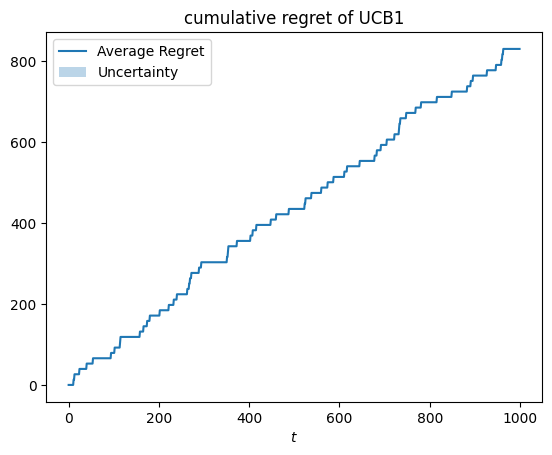

In [23]:
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

In [27]:
agent.N_pulls

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

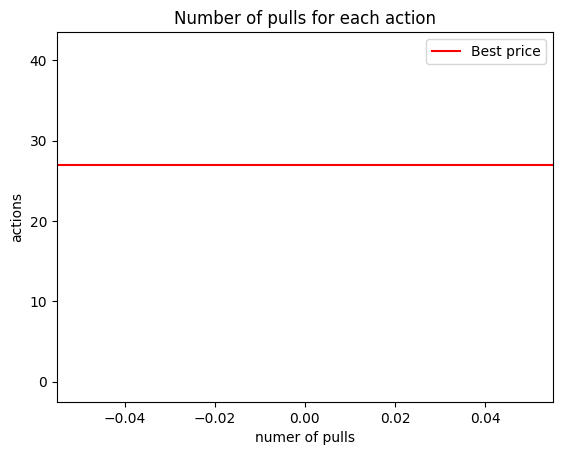

In [26]:
plt.figure()
plt.barh(np.arange(len(agent.N_pulls)), agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show()